In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

sns.set()

%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Bidirectional, LSTM, Embedding, Dropout, SpatialDropout1D, Layer
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
from tensorflow.keras import initializers 
from tensorflow.keras import regularizers
from tensorflow.keras import constraints

from tensorflow.keras import activations 
from tensorflow.keras import backend as K

In [4]:
from sklearn.metrics import roc_auc_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

In [5]:
data_dir = "C:/Users/Kelvin Chumbe/Downloads/Datasets/Capstone_Twitter Modelling Datasets/Disaster Tweets Combined/"

In [6]:
# Load in preprocessed tweets
tweets = pd.read_csv(os.path.join(data_dir, 'Preprocessed_tweets.csv'))

In [7]:
tweets_copy = tweets.copy()

In [8]:
tweets.head()

,ID,Tweet,Category
0,592293488399491073',president pranab mukherjee speaks to nepal pre...,Sympathy and Support
1,3.912224263545897e+17,horrid bush fires in nsw feeling for all those...,Sympathy and Support
2,593042251401461760',im relief to know that my friend is alright af...,Sympathy and Support
3,541821995206586369',it was so good to be back on today sending lov...,Sympathy and Support
4,2.1802996308811776e+17,praying for my cousins and everyone else in co...,Sympathy and Support


In [9]:
tweets.shape

(19015, 3)

In [10]:
tweets = tweets.drop('ID',axis=1)

In [11]:
GLOVE_DIR = "C:/Users/Kelvin Chumbe/Downloads/Datasets/GloVe_archive/GloVe 6B"

In [12]:
# # Create glove embeddings dict from glove file
glove_file = "glove.6B.100d.txt"
glove_path = os.path.join(GLOVE_DIR, glove_file)
glove_embeddings= {}

EMBEDDING_DIM = int(glove_file.split(".")[2][:-1])

with open(glove_path, encoding='utf8') as file:
    for line in file:
        line = line.split()
        word = line[0]
        embedding = line[1:]

        glove_embeddings[word] = np.asarray(embedding, dtype='float32')

In [13]:
oov_dict = {}

oov_file = 'C:/Users/Kelvin Chumbe/Downloads/Datasets/Capstone_Twitter Modelling Datasets/OOV_Dict/OOV_Dict/OOV_Dictionary_V1.0.tsv'
i = 0

with open(oov_file, 'r') as file:
    for line in file:
        line_arr = line.split('\t')
        oov_word = line_arr[0]
        oov_translation = line_arr[1].strip()
        oov_dict[oov_word] = oov_translation

In [14]:
tweets['Tweet'] = tweets['Tweet'].apply(lambda x: [oov_dict.get(word, word) for word in str(x).split(" ")])

In [15]:
# tweets['Tweet'] = tweets['Tweet'].apply(lambda x: str(x).split(" "))

In [16]:
tweets['Tweet'].str.len().max()

35

In [17]:
# Tokenize and pad tweets
tweets_text = tweets['Tweet']

tokenizer = Tokenizer()
tokenizer.fit_on_texts(tweets_text)
sequences = tokenizer.texts_to_sequences(tweets_text)

sequence_max_len = 35

tweets_text = pad_sequences(sequences, maxlen=sequence_max_len, padding='post')

print('Found {} unique tokens.'.format(len(tokenizer.word_index)))

Found 22514 unique tokens.


In [18]:
# Save the tokenizer object
tokenizer_file = "tokenizer.pkl"

pickle.dump(tokenizer, open(tokenizer_file, "wb"))

In [19]:
tokenizer = pickle.load(open(tokenizer_file, 'rb'))

In [20]:
# Create weight matrix
embedding_matrix = np.random.random((len(tokenizer.word_index) + 1, EMBEDDING_DIM))

for word, i in tokenizer.word_index.items():
    #    embedding_vec = glove_embeddings.get(word)
    #    embedding_vec = word2vec_model[word]
    try: 
        embedding_vec = glove_embeddings.get(word)
    except:
        pass
    
    if embedding_vec is not None:
        embedding_matrix[i] = embedding_vec

In [21]:
labels_dict = {
 'Sympathy and Support': 0,
 'Caution and Advice': 1,
 'Relief Request and Donations': 2,
 'Damage Report': 3,
 'Casualty': 4}

In [22]:
labels_dict_inversed = {}

for k,v in labels_dict.items():
    labels_dict_inversed[v] = k

In [23]:
tweets['Labels'] = tweets['Category'].apply(lambda x: labels_dict.get(x))

In [24]:
# Convert Categories to one-hot encoding
labels = to_categorical(tweets['Labels'])

In [25]:
labels[:5]

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [26]:
tweets['Category'][:5]

0    Sympathy and Support
1    Sympathy and Support
2    Sympathy and Support
3    Sympathy and Support
4    Sympathy and Support
Name: Category, dtype: object

In [27]:
def reverseEncoded(labels):
    return np.argmax(labels, axis=1)

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
train_X, test_X, train_Y, test_Y = train_test_split(tweets_text, labels, test_size=0.2, random_state=0, shuffle=True)

In [30]:
train_X_copy, test_X_copy, train_Y_copy, test_Y_copy = train_test_split(tweets_copy['Tweet'], labels, test_size=0.8, random_state=0, shuffle=True)

In [31]:
labels[:5]

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [32]:
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras import constraints
from tensorflow.keras.layers import Layer
from tensorflow.keras import initializers
from tensorflow.keras import activations

In [33]:
# AttentionWithContext adapted for Tensorflow 1.13 with Eager Execution.
# IMPORTANT -you can't use regular keras optimizers.  You need to grab one that is subclassed from 
# tf.train.Optimizer.   Not to worry, your favorite is probably there, for example - 
# https://www.tensorflow.org/api_docs/python/tf/train/AdamOptimizer

# That's it, now you can use this layer - 
# Adapted from https://gist.github.com/cbaziotis/7ef97ccf71cbc14366835198c09809d2

# Tested using functional API.   Just plop on top of an RNN, like so - 

# x = Embedding(*embedding_matrix.shape, weights=[embedding_matrix], input_length=max_topic_length, trainable=False)(inputs)
# x1 = LSTM(return_sequences=True)(x)
# c1 = AttentionWithContext()(x1)

import tensorflow as tf
from tensorflow.keras import initializers 
from tensorflow.keras import regularizers
from tensorflow.keras import constraints

from tensorflow.keras import activations 
from tensorflow.keras import backend as K

from tensorflow.keras.layers import Layer

class AttentionWithContext(Layer):
    """
        Attention operation, with a context/query vector, for temporal data.
        Supports Masking.
        Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
        "Hierarchical Attention Networks for Document Classification"
        by using a context vector to assist the attention
        # Input shape
            3D tensor with shape: `(samples, steps, features)`.
        # Output shape
            2D tensor with shape: `(samples, features)`.
        :param kwargs:
        Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
        The dimensions are inferred based on the output shape of the RNN.
        Example:
            model.add(LSTM(64, return_sequences=True))
            model.add(AttentionWithContext())
        """

    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True,
                 return_attention=False, **kwargs):

        self.supports_masking = True
        self.return_attention = return_attention
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3
        input_shape_list = input_shape.as_list()

        self.W = self.add_weight(shape=((input_shape_list[-1], input_shape_list[-1])),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight(shape=(input_shape_list[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

        self.u = self.add_weight(shape=(input_shape_list[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape.as_list())

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        uit = tf.tensordot(x, self.W,axes=1)

        if self.bias:
            uit += self.b

        uit = activations.tanh(uit)
        # ait = K.dot(uit, self.u)
        ait = tf.tensordot(uit, self.u,axes=1)

        a = activations.exponential(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= tf.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= tf.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        result = K.sum(weighted_input, axis=1)

        if self.return_attention:
            return [result, a]
        return result

    def compute_output_shape(self, input_shape):
        if self.return_attention:
            #TODO use TensorShape here, as done in the else statement.   I'm not sure
            # if this is returning a single tensor, or a list of two so leaving this undone for now.  Suspect this will
            # need to complete if using Sequential rather than Functional API
            return [(input_shape[0], input_shape[-1]),
                    (input_shape[0], input_shape[1])]
        else:
            return tf.TensorShape([input_shape[0].value,input_shape[-1].value])

        
    def get_config(self):
        config = {
            'W_regularizer': initializers.serialize(self.W_regularizer),
            'u_regularizer': initializers.serialize(self.u_regularizer),
            'b_regularizer': initializers.serialize(self.b_regularizer),

            'W_constraint': constraints.serialize(self.W_constraint),
            'u_constraint': constraints.serialize(self.u_constraint),
            'b_constraint': constraints.serialize(self.b_constraint),

            'return_attention': self.return_attention,

            'bias': self.bias,
        }

        base_config = super(AttentionWithContext, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [34]:
# Build a Classification Model
model = Sequential([
    Embedding(len(tokenizer.word_index) + 1, 
              EMBEDDING_DIM,
              weights=[embedding_matrix],
              input_length=sequence_max_len,
              trainable=False),
    SpatialDropout1D(0.2),
    Bidirectional(LSTM(200, recurrent_dropout=0.2, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(200, recurrent_dropout=0.2, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(200, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(200)),
    Dropout(0.2),
    
#     AttentionWithContext(),
    
    Dense(512, activation='relu'),
    Dropout(0.4),
    Dense(5, activation='softmax')
])

In [35]:
model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(lr=0.0001), 
              metrics=['accuracy'])

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 35, 100)           2251500   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 35, 100)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 35, 400)           481600    
_________________________________________________________________
dropout (Dropout)            (None, 35, 400)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 35, 400)           961600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 35, 400)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 35, 400)           9

In [37]:
# filepath = "best_model_glove_attention_200d.h5"

filepath = "best_model_base.h5"

model_checkpoint = ModelCheckpoint(
    filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
)

In [38]:
EPOCHS = 4  #2
BATCH_SIZE = 256

history = model.fit(train_X, 
                    train_Y, 
                    validation_split=0.2, 
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    callbacks=[model_checkpoint])

Epoch 1/4
48/48 [==============================] - 250s 5s/step - loss: 1.5071 - accuracy: 0.3316 - val_loss: 1.2112 - val_accuracy: 0.5501
Epoch 2/4
48/48 [==============================] - 240s 5s/step - loss: 1.0764 - accuracy: 0.5713 - val_loss: 0.8759 - val_accuracy: 0.6885
Epoch 3/4
48/48 [==============================] - 279s 6s/step - loss: 0.8841 - accuracy: 0.6669 - val_loss: 0.7470 - val_accuracy: 0.7381
Epoch 4/4
48/48 [==============================] - 278s 6s/step - loss: 0.8136 - accuracy: 0.6923 - val_loss: 0.6934 - val_accuracy: 0.7522


In [39]:
filepath

'best_model_base.h5'

In [40]:
# Load model
model_filepath = os.path.join(data_dir, filepath)

model = tf.keras.models.load_model(filepath)
# model = tf.keras.models.load_model(filepath, custom_objects={'AttentionWithContext': AttentionWithContext})

In [41]:
loss, accuracy = model.evaluate(test_X, test_Y)
print("Loss: {}\nAccuracy: {}".format(loss, accuracy))

119/119 [==============================] - 45s 378ms/step - loss: 0.7158 - accuracy: 0.7449
Loss: 0.7158308625221252
Accuracy: 0.7449381947517395


In [42]:
y_preds = model.predict(test_X)

In [43]:
y_preds_classes = reverseEncoded(y_preds)

In [44]:
test_Y_classes = reverseEncoded(test_Y)

In [45]:
def evaluate_model(model, test_X, test_Y_classes, y_preds_classes, label_names):
    print("Classification Report: \n")
    print(classification_report(test_Y_classes, y_preds_classes, target_names=label_names))
    
    confusion_mx = confusion_matrix(test_Y_classes, y_preds_classes)
    
    fig = plt.figure(figsize=(10,8))
    ax = fig.gca()
    sns.heatmap(confusion_mx, annot=True, fmt=".0f", ax=ax, cmap=plt.cm.Blues,
                xticklabels=label_names, 
                yticklabels=label_names)
    
    print("ROC AUC Score: ", roc_auc_score(test_Y_classes, model.predict_proba(test_X), multi_class='ovr'))

Classification Report: 

                              precision    recall  f1-score   support

        Sympathy and Support       0.73      0.78      0.75       769
          Caution and Advice       0.66      0.75      0.70       837
Relief Request and Donations       0.74      0.79      0.77       792
               Damage Report       0.80      0.54      0.64       777
                    Casualty       0.85      0.88      0.87       628

                    accuracy                           0.74      3803
                   macro avg       0.76      0.75      0.75      3803
                weighted avg       0.75      0.74      0.74      3803

Instructions for updating:
Please use `model.predict()` instead.
ROC AUC Score:  0.9333581614133619


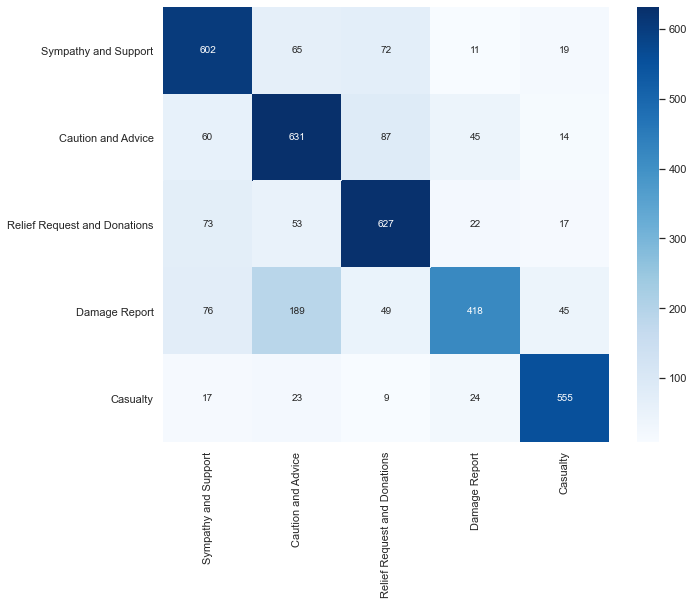

In [46]:
evaluate_model(model, test_X, test_Y_classes, y_preds_classes, labels_dict.keys())